In [1]:
import itertools
import os
import sys
import copy
sys.path.append("colorization_pytorch")
sys.path.append("flownet2_pytorch")
import torch
import torch.nn as nn
from colorization_pytorch.models import create_model
from flownet2_pytorch.models import FlowNet2
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from datasets import *
from torch.utils.data import DataLoader
from tqdm import tqdm
from colorization_pytorch.options.train_options import TrainOptions
from flownet2_pytorch.parser import initialize_args
import torchvision.transforms as transforms
from colorization_pytorch.util import util
from util.visualizer import save_images
from util import html

to_visualize = ['gray', 'hint', 'hint_ab', 'fake_entr', 'real', 'fake_reg', 'real_ab', 'fake_ab_reg']
class Mask(nn.Module):
    def __init__(self, in_channels):
        super(Mask,self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
        )

    def forward(self, data):
        return self.cnn(data)


class VideoColorization(nn.Module):
    def __init__(self, opt, args, batchNorm=False, div_flow=20.):
        super(VideoColorization,self).__init__()
        self.opt = opt
        self.color_model = create_model(opt)
        self.color_model.setup(opt)
        self.color_model.print_networks(False)
        self.flownet = FlowNet2(args, batchNorm=batchNorm, div_flow=div_flow)
        checkpoint = torch.load(args.resume)
        self.flownet.load_state_dict(checkpoint['state_dict'])
        #self.ori_index = torch.tensor(list(itertools.product(np.arange(H), np.arange(W)))). \
            #reshape(H, W, -1)
        self.mask = Mask(256)

    def forward(self, color_data, flow_data):
        self.color_model.set_input(color_data[0])
        _,_, previous_feature_map = self.color_model.encode()
        self.color_model.set_input(color_data[1])
        conv1_2, conv2_2, feature_map = self.color_model.encode()
        flow = self.flownet(flow_data)  # B * 2 * 384 * 1024
        #print("flow")
        FlowWeight = F.interpolate(flow, previous_feature_map.size()[-2:], mode='bilinear')
        B, C, H, W = previous_feature_map.size()
        #print(previous_feature_map.shape)
        flow_copy = FlowWeight.clone().detach().cpu().long().permute(0, 2, 3, 1)
        predicted_feature_map = torch.zeros(previous_feature_map.shape).cuda()
        for h in range(H):
            for w in range(W):
                res_h = h + flow_copy[0,h,w,0]
                res_w = w + flow_copy[0,h,w,1]
                if res_h < 0:
                    res_h = 0
                elif res_h > H-1:
                    res_h = H-1
                if res_w < 0:
                    res_w = 0
                elif res_w > W-1:
                    res_w = W-1
                predicted_feature_map[:,:,res_h,res_w] = previous_feature_map[:,:,h,w]
            
        # B*512*22*22
        #print(predicted_feature_map.shape)
        delta_feature_map = torch.abs(predicted_feature_map - feature_map)
        M = self.mask(delta_feature_map)
        #print(M.shape)
        output_feature_map = (1 - M) * feature_map + M * predicted_feature_map
        fake_B_class, fake_B_reg = self.color_model.decode(conv1_2, conv2_2, output_feature_map)
        #print(fake_B_reg.shape)
        return fake_B_reg, FlowWeight
        
    def infer_forward(self, color_data, flow_data, previous_feature_map=[]):
        if len(previous_feature_map) == 0:
            self.color_model.set_input(color_data[0])
            _,_, previous_feature_map = self.color_model.encode()
        self.color_model.set_input(color_data[1])
        conv1_2, conv2_2, feature_map = self.color_model.encode()
        flow = self.flownet(flow_data)  # B * 2 * 384 * 1024
        #print("flow")
        FlowWeight = F.interpolate(flow, previous_feature_map.size()[-2:], mode='bilinear')
        B, C, H, W = previous_feature_map.size()
        #print(previous_feature_map.shape)
        flow_copy = FlowWeight.clone().detach().cpu().long().permute(0, 2, 3, 1)
        predicted_feature_map = torch.zeros(previous_feature_map.shape).cuda()
        for h in range(H):
            for w in range(W):
                res_h = h + flow_copy[0,h,w,0]
                res_w = w + flow_copy[0,h,w,1]
                if res_h < 0:
                    res_h = 0
                elif res_h > H-1:
                    res_h = H-1
                if res_w < 0:
                    res_w = 0
                elif res_w > W-1:
                    res_w = W-1
                predicted_feature_map[:,:,res_h,res_w] = previous_feature_map[:,:,h,w]
            
        # B*512*22*22
        #print(predicted_feature_map.shape)
        delta_feature_map = torch.abs(predicted_feature_map - feature_map)
        M = self.mask(delta_feature_map)
        #print(M.shape)
        output_feature_map = (1 - M) * feature_map + M * predicted_feature_map
        #fake_B_class, fake_B_reg = self.color_model.decode(conv1_2, conv2_2, output_feature_map)
        fake_B_class, fake_B_reg = self.color_model.decode(conv1_2, conv2_2, feature_map)
        #print(fake_B_reg.shape)
        return fake_B_reg, FlowWeight, output_feature_map
    
    def debug_test(self, color_data, flow_data, i, previous_feature_map=[]):
        self.color_model.eval()
        img_path = ['%08d_%.3f' % (i,1)]
        web_dir = os.path.join(self.color_model.opt.results_dir, self.color_model.opt.name, '%s_%s' % (self.color_model.opt.phase, self.color_model.opt.which_epoch))
        webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (self.color_model.opt.name, self.color_model.opt.phase, self.color_model.opt.which_epoch))
        self.color_model.set_input(color_data)
        self.color_model.forward()
        #self.color_model.test(True)
        visuals = util.get_subset_dict(self.color_model.get_current_visuals(), to_visualize)
        save_images(webpage, visuals, img_path, aspect_ratio=self.color_model.opt.aspect_ratio, width=self.color_model.opt.display_winsize)
        #self.color_model.forward()
        return self.color_model.fake_B_reg

        
class flow_args():
    def __init__(self):
        self.rgb_max = 255
        self.fp16 = False
        self.fp16_scale = 1024.
        self.crop_size = [256,256]
        self.inference_size = [-1,-1]
        self.resume = './check_point/FlowNet2_checkpoint.pth.tar'
        

opt = TrainOptions().parse()
args = flow_args()
debug = VideoColorization(opt, args)


----------------- Options ---------------
                   ab_max: 110.0                         
                  ab_norm: 110.0                         
                 ab_quant: 10.0                          
             aspect_ratio: 1.0                           
           avg_loss_alpha: 0.986                         
               batch_size: 8                             
                    beta1: 0.9                           
          checkpoints_dir: ./colorization_pytorch/checkpoints
           classification: False                         
             dataset_mode: aligned                       
             display_freq: 200                           
               display_id: 1                             
            display_ncols: 5                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 384                           
              epoch_count:

In [2]:
train_set = MpiSintel(args, root = "data/training/")
#test_set = MpiTest(args, root = "data/test/")
test_loader = DataLoader(train_set, batch_size = 1, shuffle=False, num_workers=4)
#train_loader = DataLoader(train_set, batch_size = 8, shuffle=True, num_workers=4)

In [3]:
class solver():
    def __init__(self, model):
        self.model = model
        self.lr = 1e-4
        self.optimizer_flow = torch.optim.Adam(self.model.flownet.parameters(), lr=2e-4)
        self.optimizer_color_network = []
        self.use_D = opt.lambda_GAN > 0
        self.optimizer_G = torch.optim.Adam(self.model.color_model.netG.parameters(),
                                            lr=0, betas=(opt.beta1, 0.999)) #lr=opt.lr
        self.optimizer_color_network.append(self.optimizer_G)

        if self.use_D:
            self.optimizer_D = torch.optim.Adam(self.model.color_model.netD.parameters(),
                                                    lr=0, betas=(opt.beta1, 0.999))
            self.optimizer_color_network.append(self.optimizer_D)
        
        self.optimizer_mask = torch.optim.Adam(self.model.mask.parameters(), lr=1e-4)
        self.batch_size = 5
        self.epoch = 100
        self.H = 384
        self.W = 1024
        #self.ori_index = torch.tensor(list(itertools.product(np.arange(self.H), np.arange(self.W)))). \
         #   reshape(self.H, self.W, -1)
        
    def plot_grad_flow(self, named_parameters):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.
    
        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
        plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
        plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(left=0, right=len(ave_grads))
        plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.legend([matplotlib.lines.Line2D([0], [0], color="c", lw=4),
                matplotlib.lines.Line2D([0], [0], color="b", lw=4),
                matplotlib.lines.Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
        plt.show()
        
    def pixel_flow(self, flow, img):
        flow_copy = flow.clone().detach().cpu().long().permute(0, 2, 3, 1)
        B, C, H, W = img.size()
        next_img = torch.zeros(img.shape).cuda()
        for h in range(H):
            for w in range(W):
                res_h = h + flow_copy[0,h,w,0]
                res_w = w + flow_copy[0,h,w,1]
                if res_h < 0:
                    res_h = 0
                elif res_h > H-1:
                    res_h = H-1
                if res_w < 0:
                    res_w = 0
                elif res_w > W-1:
                    res_w = W-1
                next_img[:,:,res_h,res_w] = img[:,:,h,w]
        return next_img
        
    def eval_metric(self, O_1, O_2, flow, mask):
        R_2 = self.pixel_flow(flow, O_1)
        Estab = torch.sum(mask * (O_2 - R_2) * (O_2 - R_2))
        return Estab
    
    def cohe_loss(self, O_2, S_1, flow, mask):
        R_2 = self.pixel_flow(flow, S_1)
        L_cohe = torch.sum(mask * (O_2 - R_2) * (O_2 - R_2))
        print (self.alpha*L_cohe)
        return L_cohe
    
    def occ_loss(self, O_2, S_2, mask):
        L_occ = torch.sum((1-mask) * (O_2 - S_2) * (O_2 - S_2))
        print (self.beta*L_occ)
        return L_occ
        
    def flow_loss(self, F_est, flow):
        F_down = F.interpolate(flow, F_est.size()[-2:], mode='bilinear')
        L_flow = torch.sum((F_est-F_down) * (F_est-F_down))
        print (self.gamma*L_flow)
        return L_flow
        
    def train(self, train_loader):
        self.alpha = 1e-6
        self.beta = 2e-7
        self.gamma = 5e-5
        self.train_records = []
        for epoch in range(1, self.epoch):
            batch = 0
            epoch_cohe_loss = 0
            epoch_occ_loss = 0
            epoch_flow_loss = 0
            epoch_total_loss = 0
            
            for Img, flow, mask in tqdm(train_loader):
                batch+=1
                Img = Img.cuda()
                flow = flow.cuda()
                mask = mask.type(torch.FloatTensor).cuda()
                #print(flow.shape)
                #print(mask.shape)
                temp_1 = util.get_colorization_data(Img[:,:,0,:,:].unsqueeze(0),self.model.opt)
                I_1 = temp_1['A'].unsqueeze(1)
                S_1 = temp_1['B']
                I_1 = I_1.repeat(1,3,1,1,1)
                temp_2 = util.get_colorization_data(Img[:,:,1,:,:].unsqueeze(0),self.model.opt)
                I_2 = temp_2['A'].unsqueeze(1)
                S_2 = temp_2['B']
                I_2 = I_2.repeat(1,3,1,1,1)
                inp = torch.cat((I_1,I_2), dim=2)
                self.optimizer_flow.zero_grad()
#                 self.optimizer_G.zero_grad()
                self.optimizer_mask.zero_grad()
                O_2, F_est = self.model([temp_1,temp_2],inp)
                #print(F_est.shape)
                
                lcohe = self.alpha*self.cohe_loss(O_2,S_1,flow,mask)
                locc = self.beta*self.occ_loss(O_2,S_2,mask)
                #lflow = self.gamma*self.flow_loss(F_est,flow)
                loss = lcohe+locc#+lflow
                epoch_cohe_loss+=lcohe.cpu().item()
                epoch_occ_loss+=locc.cpu().item()
                #epoch_flow_loss+=lflow.cpu().item()
                epoch_total_loss+=loss.cpu().item()
                
                print(batch, loss)
                print(epoch_cohe_loss / batch, epoch_occ_loss / batch, epoch_total_loss / batch)
                loss.backward()
                #self.optimizer_flow.step()
                #self.optimizer_G.step()
                self.optimizer_mask.step()
                del Img
                del flow
                del mask
            
            print ('epoch_cohe_loss', epoch_cohe_loss/batch)
            print ('epoch_occ_loss', epoch_occ_loss/batch)
            #print ('epoch_flow_loss', epoch_flow_loss/batch)
            print ('epoch_total_loss', epoch_total_loss/batch)
            self.train_records.append([epoch_cohe_loss/batch, epoch_occ_loss/batch, epoch_total_loss/batch])
            
    def inference(self, test_loader, ground_true = True):
        self.model.eval()
        I_1 = []
        F_1 = []
        res = []
        batch = 0
        for Img, flow, mask in tqdm(test_loader):
            res_temp = []
            batch+=1
            Img = Img.cuda()
            if len(I_1) == 0:
                temp_1 = util.get_colorization_data(Img[:,:,0,:,:].unsqueeze(0),self.model.opt)
                I_1 = temp_1['A'].unsqueeze(1)
                S_1 = temp_1['B']
                res.append(Img[:,:,0,:,:])
                I_1 = I_1.repeat(1,3,1,1,1)
            temp_2 = util.get_colorization_data(Img[:,:,1,:,:].unsqueeze(0),self.model.opt)
            res_temp.append(temp_2['A'])
            I_2 = temp_2['A'].unsqueeze(1)
            S_2 = temp_2['B']
            I_2 = I_2.repeat(1,3,1,1,1)
            inp = torch.cat((I_1,I_2), dim=2)
            O_2, F_est, F_1 = self.model.infer_forward([temp_1,temp_2],inp, F_1)
            res_temp.append(O_2)
            res.append(res_temp)
            del I_1
            del temp_1
            I_1 = I_2
            temp_1 = temp_2
            if batch == 20:
                return res
            
        return res
    
    def debug_test(self, test_loader):
        res = []
        batch = 0
        self.model.eval()
        for Img, flow, mask in tqdm(test_loader):
            Img = Img.cuda()
            print("img shape is:", Img.size())
            res_temp = []
            temp_1 = util.get_colorization_data([Img[:,:,0,:,:],0],self.model.opt, ab_thresh=0.)
            res_temp.append(temp_1['A'])
            O_2 = self.model.debug_test(temp_1,None, batch)
            res_temp.append(O_2)
            res_temp.append(temp_1['B'])
            res.append(res_temp)
            batch+=1
            if batch == 20:
                return res
        

In [4]:
debug = debug.cuda()
#debug.load_state_dict(torch.load("2.model"))
solv = solver(debug)
res = solv.debug_test(test_loader)

  0%|          | 0/1041 [00:00<?, ?it/s]

img shape is: torch.Size([1, 3, 2, 256, 256])


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
colorization_pytorch/util/util.py:326: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  a_range = torch.range(-opt.ab_max, opt.ab_max, step=opt.ab_quant).to(data_ab_quant.device)[None,:,None,None]


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  0%|          | 1/1041 [00:03<53:36,  3.09s/it]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  0%|          | 2/1041 [00:03<39:13,  2.27s/it]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  0%|          | 3/1041 [00:03<28:57,  1.67s/it]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  0%|          | 4/1041 [00:04<21:49,  1.26s/it]

img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  0%|          | 5/1041 [00:04<16:48,  1.03it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|          | 6/1041 [00:04<13:17,  1.30it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|          | 7/1041 [00:04<10:47,  1.60it/s]

img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|          | 8/1041 [00:05<09:04,  1.90it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|          | 9/1041 [00:05<07:58,  2.16it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|          | 10/1041 [00:05<07:09,  2.40it/s]

img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|          | 11/1041 [00:06<06:32,  2.62it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|          | 12/1041 [00:06<06:09,  2.79it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|          | 13/1041 [00:06<05:51,  2.93it/s]

img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|▏         | 14/1041 [00:07<05:38,  3.03it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  1%|▏         | 15/1041 [00:07<05:32,  3.09it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  2%|▏         | 16/1041 [00:07<05:27,  3.13it/s]

img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  2%|▏         | 17/1041 [00:07<05:28,  3.11it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  2%|▏         | 18/1041 [00:08<05:25,  3.14it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


  2%|▏         | 19/1041 [00:08<05:24,  3.15it/s]

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
img shape is: torch.Size([1, 3, 2, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


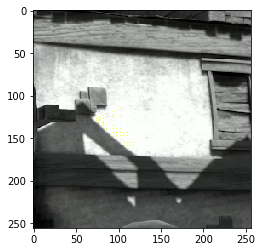

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


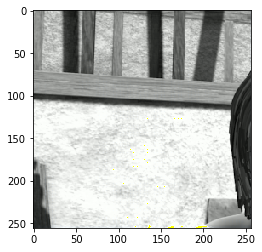

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


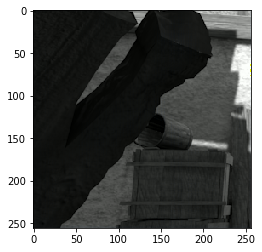

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


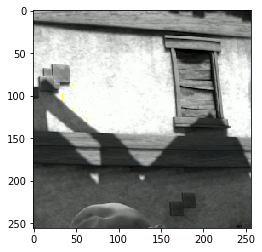

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


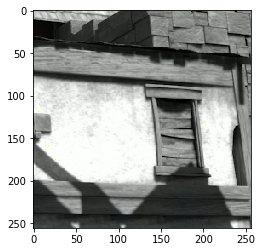

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


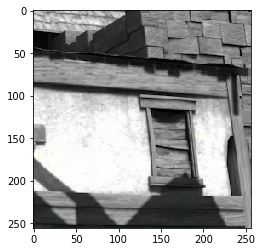

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


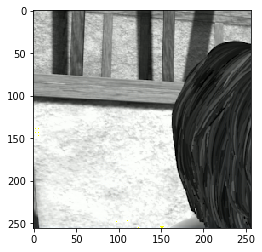

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


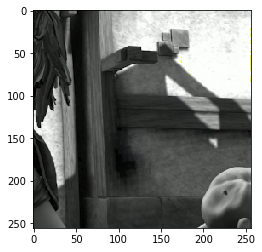

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


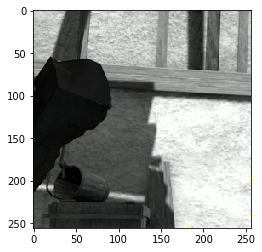

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


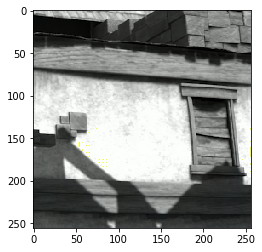

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


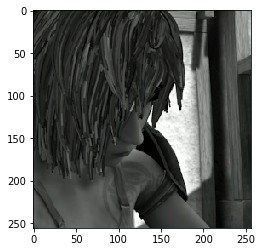

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


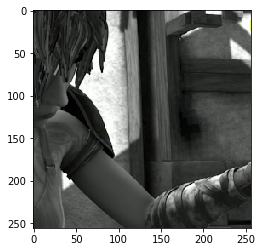

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


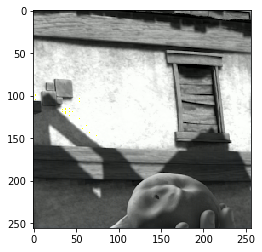

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


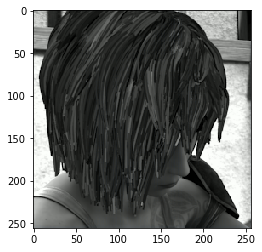

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


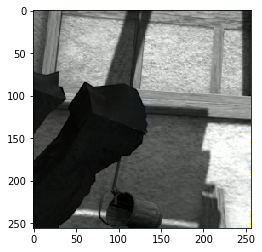

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


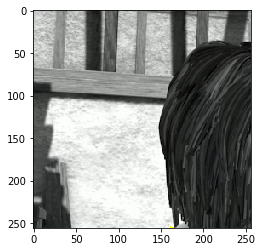

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


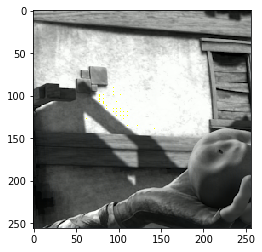

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


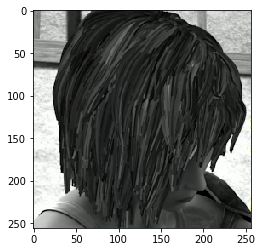

torch.Size([1, 1, 256, 256])
torch.Size([1, 2, 256, 256])
torch.Size([1, 3, 256, 256])
<class 'numpy.ndarray'>
(256, 256, 3)


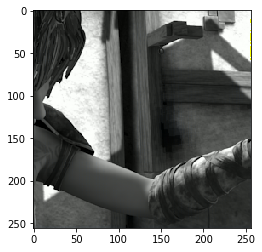

In [5]:
import PIL
from colorization_pytorch.util import util
for i in range(len(res)):
    #print(res[i].shape)
    if i==0:
        continue
        color_img = res[0].cpu().squeeze(0).permute(1,2,0).numpy()
    else:
        print(res[i][0].shape)
        print(res[i][1].shape)
        temp = util.lab2rgb(torch.cat((res[i][0].type(torch.FloatTensor), res[i][1].type(torch.FloatTensor)), dim=1), opt)
        color_img = temp.cpu().squeeze(0).permute(1,2,0).detach().numpy()
    print(type(color_img))
    print(color_img.shape)
    color_img = np.uint8(color_img)
    color_img = PIL.Image.fromarray(color_img)
    plt.imshow(color_img)
    plt.show()

In [6]:
for i in range(len(res)):
    print("Gray:")
    print(res[i][0][0,:,0:10,0:10])
    print("O_2:")
    print(res[i][1][0,:,0:10,0:10])
    print("GT:")
    print(res[i][2][0,:,0:10,0:10])

Gray:
tensor([[[ 9.0318,  9.6931, 10.6986, 11.6824, 12.1337, 11.6489, 11.0509,
          11.0509, 10.6646, 10.0532],
         [ 8.6627,  9.0318,  9.6931, 11.1593, 11.6489, 12.1337, 11.6489,
          11.5418, 10.6646,  9.6931],
         [ 9.1463,  8.6275,  9.1812, 10.6646, 11.1930, 12.0277, 11.6489,
          11.1593, 10.1645,  9.6585],
         [ 9.6931,  9.0318,  9.1812, 10.6646, 11.1593, 11.6489, 11.5418,
          11.0509, 10.5548, 10.1645],
         [10.5548,  9.6931,  9.6585, 11.1593, 11.6489, 11.6489, 11.5418,
          11.1593, 11.0509, 10.6646],
         [10.5548, 10.6646, 10.6986, 11.1593, 11.6489, 11.0509, 11.0509,
          11.1593, 11.0509, 10.6646],
         [ 8.5110,  9.5457, 11.1593, 11.6489, 11.1593, 10.1645, 10.1645,
          10.6646, 10.5548, 10.1645],
         [ 7.6030,  7.4462,  9.6585, 10.6646, 10.1645,  9.6585,  9.6585,
          10.0532,  9.6585,  9.6585],
         [ 9.6585,  8.6275, 10.0532, 10.6646, 10.1988, 10.1645,  9.6585,
           9.6585,  9.5457,  9.54

tensor([[[-0.5353, -0.9997, -0.9998, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.9971, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.9990, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.9995, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.9996, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.9997, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
         [-0.9999, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000],
 

tensor([[[11.9633,  9.7455,  9.7588, 10.4378,  8.5571,  7.0427,  7.3425,
           6.4281,  7.7458,  7.8888],
         [11.6537,  9.7455,  9.4609, 10.4510,  8.2594,  7.7581,  7.7922,
           5.7791,  7.4614,  7.9572],
         [11.7000, 10.1892,  9.4560, 10.1020,  8.3939,  8.2037,  7.5920,
           5.7791,  7.5337,  8.3004],
         [11.3424,  9.8047,  8.1258,  9.7708,  8.3489,  8.2037,  8.1432,
           6.1058,  7.4475,  7.8237],
         [11.3888, 10.1892,  6.2283,  7.2263,  8.2183,  8.2804,  8.2340,
           7.0611,  7.1611,  9.0615],
         [11.6026, 10.0496,  6.4859,  6.4536,  7.7738,  8.2804,  8.6862,
           7.2311,  7.1269,  9.2066],
         [10.9755,  9.6640,  6.7924,  5.5509,  7.0945,  7.9392,  8.4349,
           7.1675,  6.9592,  9.3945],
         [10.8778,  9.2813,  7.0529,  6.2290,  7.3263,  8.9653,  8.6081,
           6.9238,  6.7465,  8.3864],
         [10.9789,  8.7814,  7.4749,  5.6524,  7.6615,  8.8830,  9.3164,
           8.0885,  6.4281,  8.1784],
 

In [ ]:
debug = debug.cuda()
solv = solver(debug)
solv.train(train_loader)

In [ ]:
res = solv.train_records
res

In [ ]:
solv.train(train_loader)

In [ ]:
solv.train_records